In [ ]:
! pip install tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model

In [2]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [3]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     

def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     
def masked_se(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse
def masked_se_clip_10(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse     

def masked_mse(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
     

def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

def masked_mse_clip_10(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
def masked_rmse_clip_10(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [5]:
datContent = [i.strip().split() for i in open("anime_ratings.dat").readlines()][1:]

In [6]:
max_user=0
max_anime=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_anime=max(max_anime,int(r[1]))
print(max_user,max_anime)

5000 7390


In [7]:
def my_proc(cont,init):
  matrix = np.full((max_user,max_anime),init)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

def my_proc_avg(cont): 
  matrix = np.full((max_user,max_anime),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [8]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
print(len(train_df),len(test_df),len(validate_df))

340153 41995 37795


In [9]:
val=0
users_items_matrix_train_zero = my_proc(train_df,val)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df,val)
users_items_matrix_test = my_proc(test_df,val)

In [10]:
users_items_matrix_train_zero.shape

(5000, 7390)

In [11]:
 def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model
     

In [12]:
# layers = [256, 512, 256]
layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

## activation

In [13]:
import gc

In [18]:
losses=[]
val_losses=[]
rmses=[]
val_rmses=[]
activations=['elu','relu','selu','tanh','sigmoid']
outer_act=['linear','sigmoid','selu']
for a in activations:
  for o in outer_act:
    gc.collect()
    Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[128,128,128,128], a, o,0, regularizer_encode, regularizer_decode)
    Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10]) 
    hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                    epochs=70,
                    batch_size=256,
                    validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
    test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
    print("outer: ",a," inner: ",o)
    print(test_result)
    loss = hist_Deep_AE.history['loss']
    val_loss = hist_Deep_AE.history['val_loss']
    rmse = hist_Deep_AE.history['masked_rmse']
    val_rmse = hist_Deep_AE.history['val_masked_rmse']
    losses.append(loss)
    val_losses.append(val_loss)
    rmses.append(rmse)
    val_rmses.append(val_rmse)


Epoch 1/70
20/20 [==============================] - 8s 328ms/step - loss: 41.5483 - masked_rmse: 5.7357 - masked_rmse_clip_10: 5.2564 - val_loss: 11.8982 - val_masked_rmse: 2.6948 - val_masked_rmse_clip_10: 2.5724
Epoch 2/70
20/20 [==============================] - 6s 294ms/step - loss: 8.7652 - masked_rmse: 2.4682 - masked_rmse_clip_10: 2.3609 - val_loss: 3.5908 - val_masked_rmse: 1.2700 - val_masked_rmse_clip_10: 1.2462
Epoch 3/70
20/20 [==============================] - 6s 292ms/step - loss: 3.3808 - masked_rmse: 1.4466 - masked_rmse_clip_10: 1.4342 - val_loss: 2.9212 - val_masked_rmse: 1.0989 - val_masked_rmse_clip_10: 1.0906
Epoch 4/70
20/20 [==============================] - 3s 171ms/step - loss: 2.7540 - masked_rmse: 1.2657 - masked_rmse_clip_10: 1.2631 - val_loss: 2.7006 - val_masked_rmse: 1.0471 - val_masked_rmse_clip_10: 1.0416
Epoch 5/70
20/20 [==============================] - 3s 171ms/step - loss: 2.5509 - masked_rmse: 1.2013 - masked_rmse_clip_10: 1.1995 - val_loss: 2.590

outer:  elu  inner:  linear
[69.38306427001953, 7.1937408447265625, 1.6932826042175293]
Epoch 1/70
20/20 [==============================] - 5s 212ms/step - loss: 54.3999 - masked_rmse: 7.0253 - masked_rmse_clip_10: 6.8362 - val_loss: 41.2369 - val_masked_rmse: 5.5222 - val_masked_rmse_clip_10: 5.5179
Epoch 2/70
20/20 [==============================] - 4s 215ms/step - loss: 51.4381 - masked_rmse: 6.8381 - masked_rmse_clip_10: 6.8362 - val_loss: 41.1265 - val_masked_rmse: 5.5196 - val_masked_rmse_clip_10: 5.5179
Epoch 3/70
20/20 [==============================] - 3s 176ms/step - loss: 51.3374 - masked_rmse: 6.8364 - masked_rmse_clip_10: 6.8362 - val_loss: 41.0483 - val_masked_rmse: 5.5197 - val_masked_rmse_clip_10: 5.5179
Epoch 4/70
20/20 [==============================] - 4s 178ms/step - loss: 51.2641 - masked_rmse: 6.8364 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9847 - val_masked_rmse: 5.5197 - val_masked_rmse_clip_10: 5.5179
Epoch 5/70
20/20 [==============================] - 5s 2

Epoch 1/70
20/20 [==============================] - 5s 217ms/step - loss: 43.8198 - masked_rmse: 5.9361 - masked_rmse_clip_10: 5.4259 - val_loss: 12.3828 - val_masked_rmse: 2.7440 - val_masked_rmse_clip_10: 2.6208
Epoch 2/70
20/20 [==============================] - 4s 230ms/step - loss: 9.4907 - masked_rmse: 2.5613 - masked_rmse_clip_10: 2.4396 - val_loss: 3.5426 - val_masked_rmse: 1.2590 - val_masked_rmse_clip_10: 1.2450
Epoch 3/70
20/20 [==============================] - 3s 168ms/step - loss: 3.4340 - masked_rmse: 1.4531 - masked_rmse_clip_10: 1.4437 - val_loss: 2.9174 - val_masked_rmse: 1.0983 - val_masked_rmse_clip_10: 1.0909
Epoch 4/70
20/20 [==============================] - 4s 182ms/step - loss: 2.7897 - masked_rmse: 1.2711 - masked_rmse_clip_10: 1.2681 - val_loss: 2.7331 - val_masked_rmse: 1.0635 - val_masked_rmse_clip_10: 1.0588
Epoch 5/70
20/20 [==============================] - 5s 248ms/step - loss: 2.5808 - masked_rmse: 1.2105 - masked_rmse_clip_10: 1.2087 - val_loss: 2.617

outer:  elu  inner:  selu
[123.14193725585938, 9.659012794494629, 1.6952980756759644]
Epoch 1/70
20/20 [==============================] - 5s 206ms/step - loss: 48.9334 - masked_rmse: 6.3408 - masked_rmse_clip_10: 5.7571 - val_loss: 23.2261 - val_masked_rmse: 3.8856 - val_masked_rmse_clip_10: 3.6948
Epoch 2/70
20/20 [==============================] - 3s 171ms/step - loss: 26.4585 - masked_rmse: 4.4499 - masked_rmse_clip_10: 4.0475 - val_loss: 12.1996 - val_masked_rmse: 2.5829 - val_masked_rmse_clip_10: 2.4720
Epoch 3/70
20/20 [==============================] - 4s 199ms/step - loss: 14.1912 - masked_rmse: 3.0764 - masked_rmse_clip_10: 2.8711 - val_loss: 5.7325 - val_masked_rmse: 1.6774 - val_masked_rmse_clip_10: 1.4941
Epoch 4/70
20/20 [==============================] - 3s 170ms/step - loss: 5.7846 - masked_rmse: 1.9548 - masked_rmse_clip_10: 1.7872 - val_loss: 3.6212 - val_masked_rmse: 1.3047 - val_masked_rmse_clip_10: 1.2391
Epoch 5/70
20/20 [==============================] - 3s 166ms/

Epoch 1/70
20/20 [==============================] - 6s 274ms/step - loss: 54.5645 - masked_rmse: 7.0374 - masked_rmse_clip_10: 6.8362 - val_loss: 41.1941 - val_masked_rmse: 5.5234 - val_masked_rmse_clip_10: 5.5179
Epoch 2/70
20/20 [==============================] - 4s 180ms/step - loss: 51.3781 - masked_rmse: 6.8387 - masked_rmse_clip_10: 6.8362 - val_loss: 41.0637 - val_masked_rmse: 5.5202 - val_masked_rmse_clip_10: 5.5179
Epoch 3/70
20/20 [==============================] - 3s 174ms/step - loss: 51.2662 - masked_rmse: 6.8365 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9809 - val_masked_rmse: 5.5200 - val_masked_rmse_clip_10: 5.5179
Epoch 4/70
20/20 [==============================] - 5s 277ms/step - loss: 51.1934 - masked_rmse: 6.8364 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9215 - val_masked_rmse: 5.5201 - val_masked_rmse_clip_10: 5.5179
Epoch 5/70
20/20 [==============================] - 3s 159ms/step - loss: 51.1408 - masked_rmse: 6.8364 - masked_rmse_clip_10: 6.8362 - val_loss

Epoch 1/70
20/20 [==============================] - 5s 203ms/step - loss: 49.5424 - masked_rmse: 6.3803 - masked_rmse_clip_10: 5.7551 - val_loss: 22.1849 - val_masked_rmse: 3.7673 - val_masked_rmse_clip_10: 3.6204
Epoch 2/70
20/20 [==============================] - 5s 244ms/step - loss: 24.4849 - masked_rmse: 4.2654 - masked_rmse_clip_10: 3.9111 - val_loss: 10.4382 - val_masked_rmse: 2.3547 - val_masked_rmse_clip_10: 2.2046
Epoch 3/70
20/20 [==============================] - 4s 180ms/step - loss: 11.3803 - masked_rmse: 2.7360 - masked_rmse_clip_10: 2.5303 - val_loss: 4.7329 - val_masked_rmse: 1.5172 - val_masked_rmse_clip_10: 1.3980
Epoch 4/70
20/20 [==============================] - 4s 179ms/step - loss: 5.0623 - masked_rmse: 1.8180 - masked_rmse_clip_10: 1.6572 - val_loss: 3.4628 - val_masked_rmse: 1.2762 - val_masked_rmse_clip_10: 1.2084
Epoch 5/70
20/20 [==============================] - 4s 231ms/step - loss: 3.3999 - masked_rmse: 1.4666 - masked_rmse_clip_10: 1.3967 - val_loss: 2.

Epoch 1/70
20/20 [==============================] - 5s 190ms/step - loss: 38.8113 - masked_rmse: 5.4995 - masked_rmse_clip_10: 5.0362 - val_loss: 6.4442 - val_masked_rmse: 1.8658 - val_masked_rmse_clip_10: 1.8357
Epoch 2/70
20/20 [==============================] - 3s 170ms/step - loss: 5.5704 - masked_rmse: 1.9511 - masked_rmse_clip_10: 1.8952 - val_loss: 3.1218 - val_masked_rmse: 1.1935 - val_masked_rmse_clip_10: 1.1860
Epoch 3/70
20/20 [==============================] - 5s 230ms/step - loss: 2.9810 - masked_rmse: 1.3509 - masked_rmse_clip_10: 1.3481 - val_loss: 2.6996 - val_masked_rmse: 1.0669 - val_masked_rmse_clip_10: 1.0620
Epoch 4/70
20/20 [==============================] - 3s 169ms/step - loss: 2.6025 - masked_rmse: 1.2367 - masked_rmse_clip_10: 1.2359 - val_loss: 2.5596 - val_masked_rmse: 1.0367 - val_masked_rmse_clip_10: 1.0324
Epoch 5/70
20/20 [==============================] - 3s 168ms/step - loss: 2.4537 - masked_rmse: 1.1910 - masked_rmse_clip_10: 1.1905 - val_loss: 2.4886

Epoch 1/70
20/20 [==============================] - 6s 211ms/step - loss: 54.4190 - masked_rmse: 7.0267 - masked_rmse_clip_10: 6.8362 - val_loss: 41.2349 - val_masked_rmse: 5.5210 - val_masked_rmse_clip_10: 5.5179
Epoch 2/70
20/20 [==============================] - 3s 176ms/step - loss: 51.4456 - masked_rmse: 6.8373 - masked_rmse_clip_10: 6.8362 - val_loss: 41.1361 - val_masked_rmse: 5.5191 - val_masked_rmse_clip_10: 5.5179
Epoch 3/70
20/20 [==============================] - 5s 243ms/step - loss: 51.3548 - masked_rmse: 6.8363 - masked_rmse_clip_10: 6.8362 - val_loss: 41.0598 - val_masked_rmse: 5.5192 - val_masked_rmse_clip_10: 5.5179
Epoch 4/70
20/20 [==============================] - 3s 175ms/step - loss: 51.2832 - masked_rmse: 6.8363 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9976 - val_masked_rmse: 5.5192 - val_masked_rmse_clip_10: 5.5179
Epoch 5/70
20/20 [==============================] - 3s 174ms/step - loss: 51.2254 - masked_rmse: 6.8363 - masked_rmse_clip_10: 6.8362 - val_loss

Epoch 1/70
20/20 [==============================] - 7s 312ms/step - loss: 38.5286 - masked_rmse: 5.4733 - masked_rmse_clip_10: 5.0181 - val_loss: 5.4915 - val_masked_rmse: 1.6706 - val_masked_rmse_clip_10: 1.5410
Epoch 2/70
20/20 [==============================] - 4s 182ms/step - loss: 4.8642 - masked_rmse: 1.8098 - masked_rmse_clip_10: 1.7733 - val_loss: 3.0723 - val_masked_rmse: 1.1788 - val_masked_rmse_clip_10: 1.1734
Epoch 3/70
20/20 [==============================] - 4s 180ms/step - loss: 2.9636 - masked_rmse: 1.3474 - masked_rmse_clip_10: 1.3452 - val_loss: 2.7251 - val_masked_rmse: 1.0750 - val_masked_rmse_clip_10: 1.0704
Epoch 4/70
20/20 [==============================] - 5s 276ms/step - loss: 2.6437 - masked_rmse: 1.2497 - masked_rmse_clip_10: 1.2487 - val_loss: 2.6125 - val_masked_rmse: 1.0496 - val_masked_rmse_clip_10: 1.0452
Epoch 5/70
20/20 [==============================] - 3s 169ms/step - loss: 2.5064 - masked_rmse: 1.2103 - masked_rmse_clip_10: 1.2097 - val_loss: 2.5107

Epoch 1/70
20/20 [==============================] - 5s 185ms/step - loss: 56.1992 - masked_rmse: 7.1258 - masked_rmse_clip_10: 6.7042 - val_loss: 32.1637 - val_masked_rmse: 4.8468 - val_masked_rmse_clip_10: 4.8366
Epoch 2/70
20/20 [==============================] - 3s 168ms/step - loss: 29.0367 - masked_rmse: 5.0421 - masked_rmse_clip_10: 5.0374 - val_loss: 14.9950 - val_masked_rmse: 3.1946 - val_masked_rmse_clip_10: 3.1903
Epoch 3/70
20/20 [==============================] - 4s 209ms/step - loss: 13.5882 - masked_rmse: 3.3122 - masked_rmse_clip_10: 3.3109 - val_loss: 7.4633 - val_masked_rmse: 2.0709 - val_masked_rmse_clip_10: 2.0665
Epoch 4/70
20/20 [==============================] - 3s 170ms/step - loss: 7.2699 - masked_rmse: 2.2399 - masked_rmse_clip_10: 2.2391 - val_loss: 4.9018 - val_masked_rmse: 1.4943 - val_masked_rmse_clip_10: 1.4893
Epoch 5/70
20/20 [==============================] - 3s 169ms/step - loss: 5.1472 - masked_rmse: 1.7321 - masked_rmse_clip_10: 1.7312 - val_loss: 4.

Epoch 1/70
20/20 [==============================] - 5s 214ms/step - loss: 56.4220 - masked_rmse: 7.1640 - masked_rmse_clip_10: 6.8362 - val_loss: 42.7634 - val_masked_rmse: 5.6313 - val_masked_rmse_clip_10: 5.5179
Epoch 2/70
20/20 [==============================] - 3s 177ms/step - loss: 52.4694 - masked_rmse: 6.9076 - masked_rmse_clip_10: 6.8362 - val_loss: 41.6140 - val_masked_rmse: 5.5477 - val_masked_rmse_clip_10: 5.5179
Epoch 3/70
20/20 [==============================] - 4s 228ms/step - loss: 51.8481 - masked_rmse: 6.8625 - masked_rmse_clip_10: 6.8362 - val_loss: 41.4626 - val_masked_rmse: 5.5374 - val_masked_rmse_clip_10: 5.5179
Epoch 4/70
20/20 [==============================] - 3s 177ms/step - loss: 51.7195 - masked_rmse: 6.8558 - masked_rmse_clip_10: 6.8362 - val_loss: 41.3921 - val_masked_rmse: 5.5357 - val_masked_rmse_clip_10: 5.5179
Epoch 5/70
20/20 [==============================] - 3s 164ms/step - loss: 51.6482 - masked_rmse: 6.8541 - masked_rmse_clip_10: 6.8362 - val_loss

Epoch 1/70
20/20 [==============================] - 6s 252ms/step - loss: 55.7257 - masked_rmse: 7.0934 - masked_rmse_clip_10: 6.6798 - val_loss: 31.1730 - val_masked_rmse: 4.7666 - val_masked_rmse_clip_10: 4.7572
Epoch 2/70
20/20 [==============================] - 4s 182ms/step - loss: 27.5847 - masked_rmse: 4.9035 - masked_rmse_clip_10: 4.8991 - val_loss: 13.8701 - val_masked_rmse: 3.0558 - val_masked_rmse_clip_10: 3.0515
Epoch 3/70
20/20 [==============================] - 4s 183ms/step - loss: 12.3602 - masked_rmse: 3.1344 - masked_rmse_clip_10: 3.1332 - val_loss: 6.7471 - val_masked_rmse: 1.9369 - val_masked_rmse_clip_10: 1.9323
Epoch 4/70
20/20 [==============================] - 5s 235ms/step - loss: 6.5768 - masked_rmse: 2.0982 - masked_rmse_clip_10: 2.0972 - val_loss: 4.5606 - val_masked_rmse: 1.4141 - val_masked_rmse_clip_10: 1.4092
Epoch 5/70
20/20 [==============================] - 3s 171ms/step - loss: 4.7972 - masked_rmse: 1.6502 - masked_rmse_clip_10: 1.6494 - val_loss: 4.

Epoch 1/70
20/20 [==============================] - 5s 206ms/step - loss: 55.3430 - masked_rmse: 7.0797 - masked_rmse_clip_10: 6.7194 - val_loss: 32.4478 - val_masked_rmse: 4.8763 - val_masked_rmse_clip_10: 4.8675
Epoch 2/70
20/20 [==============================] - 3s 173ms/step - loss: 28.5408 - masked_rmse: 4.9936 - masked_rmse_clip_10: 4.9898 - val_loss: 13.9321 - val_masked_rmse: 3.0674 - val_masked_rmse_clip_10: 3.0632
Epoch 3/70
20/20 [==============================] - 5s 268ms/step - loss: 12.5686 - masked_rmse: 3.1663 - masked_rmse_clip_10: 3.1653 - val_loss: 6.7728 - val_masked_rmse: 1.9397 - val_masked_rmse_clip_10: 1.9350
Epoch 4/70
20/20 [==============================] - 3s 156ms/step - loss: 6.7052 - masked_rmse: 2.1166 - masked_rmse_clip_10: 2.1157 - val_loss: 4.6253 - val_masked_rmse: 1.4193 - val_masked_rmse_clip_10: 1.4141
Epoch 5/70
20/20 [==============================] - 3s 171ms/step - loss: 4.9245 - masked_rmse: 1.6678 - masked_rmse_clip_10: 1.6669 - val_loss: 4.

Epoch 1/70
20/20 [==============================] - 5s 211ms/step - loss: 56.1239 - masked_rmse: 7.1473 - masked_rmse_clip_10: 6.8362 - val_loss: 42.7088 - val_masked_rmse: 5.6317 - val_masked_rmse_clip_10: 5.5179
Epoch 2/70
20/20 [==============================] - 3s 177ms/step - loss: 52.4116 - masked_rmse: 6.9068 - masked_rmse_clip_10: 6.8362 - val_loss: 41.5589 - val_masked_rmse: 5.5468 - val_masked_rmse_clip_10: 5.5179
Epoch 3/70
20/20 [==============================] - 4s 221ms/step - loss: 51.8052 - masked_rmse: 6.8624 - masked_rmse_clip_10: 6.8362 - val_loss: 41.4226 - val_masked_rmse: 5.5375 - val_masked_rmse_clip_10: 5.5179
Epoch 4/70
20/20 [==============================] - 3s 175ms/step - loss: 51.6864 - masked_rmse: 6.8563 - masked_rmse_clip_10: 6.8362 - val_loss: 41.3587 - val_masked_rmse: 5.5361 - val_masked_rmse_clip_10: 5.5179
Epoch 5/70
20/20 [==============================] - 3s 176ms/step - loss: 51.6227 - masked_rmse: 6.8547 - masked_rmse_clip_10: 6.8362 - val_loss

Epoch 1/70
20/20 [==============================] - 7s 262ms/step - loss: 55.2457 - masked_rmse: 7.0715 - masked_rmse_clip_10: 6.7123 - val_loss: 32.2165 - val_masked_rmse: 4.8578 - val_masked_rmse_clip_10: 4.8493
Epoch 2/70
20/20 [==============================] - 4s 179ms/step - loss: 28.0023 - masked_rmse: 4.9400 - masked_rmse_clip_10: 4.9363 - val_loss: 13.2325 - val_masked_rmse: 2.9791 - val_masked_rmse_clip_10: 2.9748
Epoch 3/70
20/20 [==============================] - 3s 174ms/step - loss: 11.7397 - masked_rmse: 3.0415 - masked_rmse_clip_10: 3.0406 - val_loss: 6.2618 - val_masked_rmse: 1.8424 - val_masked_rmse_clip_10: 1.8378
Epoch 4/70
20/20 [==============================] - 5s 245ms/step - loss: 6.1935 - masked_rmse: 2.0158 - masked_rmse_clip_10: 2.0150 - val_loss: 4.3594 - val_masked_rmse: 1.3619 - val_masked_rmse_clip_10: 1.3569
Epoch 5/70
20/20 [==============================] - 3s 172ms/step - loss: 4.6479 - masked_rmse: 1.6104 - masked_rmse_clip_10: 1.6095 - val_loss: 3.

## Layer width

In [14]:
losses=[]
val_losses=[]
rmses=[]
val_rmses=[]
width=[128,256,512,1024]
for w in width:
  gc.collect()
  Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[w], activation, last_activation,0, regularizer_encode, regularizer_decode)
  Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10]) 
  hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
  test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print(test_result)
  loss = hist_Deep_AE.history['loss']
  val_loss = hist_Deep_AE.history['val_loss']
  rmse = hist_Deep_AE.history['masked_rmse']
  val_rmse = hist_Deep_AE.history['val_masked_rmse']
  losses.append(loss)
  val_losses.append(val_loss)
  rmses.append(rmse)
  val_rmses.append(val_rmse)

Epoch 1/100
20/20 [==============================] - 7s 319ms/step - loss: 47.9755 - masked_rmse: 6.3445 - masked_rmse_clip_10: 5.8112 - val_loss: 20.5711 - val_masked_rmse: 3.4910 - val_masked_rmse_clip_10: 3.0731
Epoch 2/100
20/20 [==============================] - 6s 305ms/step - loss: 22.2713 - masked_rmse: 4.0887 - masked_rmse_clip_10: 3.8777 - val_loss: 10.0676 - val_masked_rmse: 2.3762 - val_masked_rmse_clip_10: 2.2363
Epoch 3/100
20/20 [==============================] - 4s 181ms/step - loss: 12.8278 - masked_rmse: 2.9498 - masked_rmse_clip_10: 2.8374 - val_loss: 6.7603 - val_masked_rmse: 1.8608 - val_masked_rmse_clip_10: 1.8220
Epoch 4/100
20/20 [==============================] - 4s 186ms/step - loss: 8.7717 - masked_rmse: 2.3673 - masked_rmse_clip_10: 2.3209 - val_loss: 5.1915 - val_masked_rmse: 1.5748 - val_masked_rmse_clip_10: 1.5433
Epoch 5/100
20/20 [==============================] - 5s 240ms/step - loss: 6.5686 - masked_rmse: 2.0093 - masked_rmse_clip_10: 1.9886 - val_los

Epoch 1/100
20/20 [==============================] - 7s 316ms/step - loss: 41.4035 - masked_rmse: 5.7449 - masked_rmse_clip_10: 5.2592 - val_loss: 14.5406 - val_masked_rmse: 2.9349 - val_masked_rmse_clip_10: 2.7544
Epoch 2/100
20/20 [==============================] - 6s 304ms/step - loss: 14.9531 - masked_rmse: 3.1952 - masked_rmse_clip_10: 3.0906 - val_loss: 6.7907 - val_masked_rmse: 1.8082 - val_masked_rmse_clip_10: 1.7376
Epoch 3/100
20/20 [==============================] - 6s 311ms/step - loss: 8.0404 - masked_rmse: 2.1894 - masked_rmse_clip_10: 2.1557 - val_loss: 4.8202 - val_masked_rmse: 1.4312 - val_masked_rmse_clip_10: 1.4140
Epoch 4/100
20/20 [==============================] - 6s 307ms/step - loss: 5.6083 - masked_rmse: 1.7740 - masked_rmse_clip_10: 1.7596 - val_loss: 4.2525 - val_masked_rmse: 1.3170 - val_masked_rmse_clip_10: 1.3087
Epoch 5/100
20/20 [==============================] - 5s 254ms/step - loss: 4.5087 - masked_rmse: 1.5728 - masked_rmse_clip_10: 1.5662 - val_loss:

Epoch 1/100
20/20 [==============================] - 10s 480ms/step - loss: 36.2591 - masked_rmse: 5.2205 - masked_rmse_clip_10: 4.8044 - val_loss: 11.4549 - val_masked_rmse: 2.4605 - val_masked_rmse_clip_10: 2.4227
Epoch 2/100
20/20 [==============================] - 8s 386ms/step - loss: 10.0486 - masked_rmse: 2.4618 - masked_rmse_clip_10: 2.3938 - val_loss: 5.8890 - val_masked_rmse: 1.5408 - val_masked_rmse_clip_10: 1.5239
Epoch 3/100
20/20 [==============================] - 9s 482ms/step - loss: 5.7315 - masked_rmse: 1.7205 - masked_rmse_clip_10: 1.7019 - val_loss: 5.0279 - val_masked_rmse: 1.3813 - val_masked_rmse_clip_10: 1.3734
Epoch 4/100
20/20 [==============================] - 11s 551ms/step - loss: 4.3302 - masked_rmse: 1.4546 - masked_rmse_clip_10: 1.4460 - val_loss: 4.8487 - val_masked_rmse: 1.3729 - val_masked_rmse_clip_10: 1.3662
Epoch 5/100
20/20 [==============================] - 8s 409ms/step - loss: 3.5483 - masked_rmse: 1.2983 - masked_rmse_clip_10: 1.2913 - val_los

Epoch 1/100
20/20 [==============================] - 18s 884ms/step - loss: 30.8720 - masked_rmse: 4.5503 - masked_rmse_clip_10: 4.1992 - val_loss: 8.8425 - val_masked_rmse: 1.8600 - val_masked_rmse_clip_10: 1.8306
Epoch 2/100
20/20 [==============================] - 15s 784ms/step - loss: 7.7076 - masked_rmse: 1.9708 - masked_rmse_clip_10: 1.9042 - val_loss: 6.8711 - val_masked_rmse: 1.5749 - val_masked_rmse_clip_10: 1.5649
Epoch 3/100
20/20 [==============================] - 15s 750ms/step - loss: 4.8360 - masked_rmse: 1.4175 - masked_rmse_clip_10: 1.4016 - val_loss: 6.7723 - val_masked_rmse: 1.6148 - val_masked_rmse_clip_10: 1.6070
Epoch 4/100
20/20 [==============================] - 16s 838ms/step - loss: 3.6752 - masked_rmse: 1.1730 - masked_rmse_clip_10: 1.1614 - val_loss: 6.7586 - val_masked_rmse: 1.6515 - val_masked_rmse_clip_10: 1.6439
Epoch 5/100
20/20 [==============================] - 15s 737ms/step - loss: 3.0210 - masked_rmse: 1.0123 - masked_rmse_clip_10: 1.0028 - val_lo

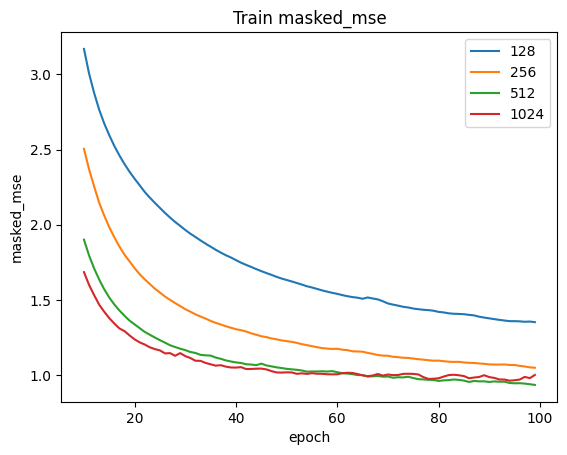

In [17]:
for loss in losses:
  plt.plot(np.arange(10, len(loss), 1), loss[10:])
plt.title('Train masked_mse')
plt.ylabel('masked_mse')
plt.xlabel('epoch')
plt.legend(['128','256','512','1024'], loc='best')
plt.show()

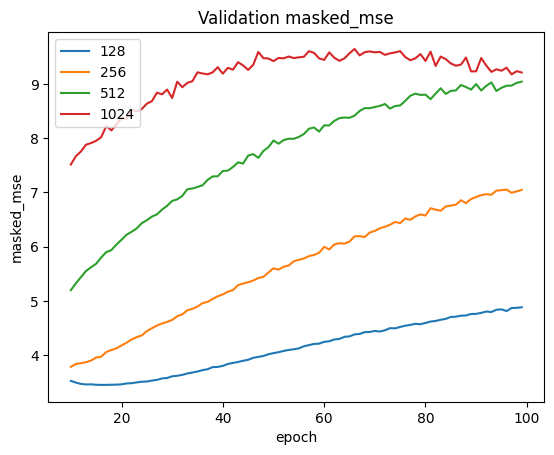

In [18]:
for loss in val_losses:
  plt.plot(np.arange(10, len(loss), 1), loss[10:])
plt.title('Validation masked_mse')
plt.ylabel('masked_mse')
plt.xlabel('epoch')
plt.legend(['128','256','512','1024'], loc='best')
plt.show()